In [1]:
import sys
sys.path.append('./')
from utils import get_sequences

import os
os.environ["BRT_ENV"] = 'prod'
import json
import random
import brtdevkit
print(brtdevkit.__version__)
brtdevkit.log = 'info'
import os
os.environ['AWS_PROFILE'] = 'default'
USERNAME = 'li.yu'

import ast
import time
import numpy as np
import pandas as pd
from datetime import datetime, timezone

# from brtdevkit.core.db.athena import AthenaClient, Table
# from brtdevkit.data import Image, Dataset
# from aletheia_dataset_creator.dataset_tools.aletheia_dataset_helpers import *
# from aletheia_dataset_creator.config.dataset_config import *

# from jupiterdata.utils.dataset import query_db
from jupiterdata.config.dataset_config import *
from jupiterdata.utils.dataset import *

pd.set_option('display.max_columns', None)

# %matplotlib inline
%load_ext autoreload
%autoreload 2

8.11.2


In [2]:
""" # run this on cmd: 
eval "$(/home/li.yu/anaconda3/bin/conda shell.bash hook)"
conda activate query
brt-devkit-auth
aws sso login --profile jupiter_prod_engineer-425642425116
"""
import inspect
print(inspect.getmodule(Dataset))
print(LEFT_CAMERAS)
REV1_LEFT_CAMERAS = ['front-center-left', 'front-left-left', 'front-right-left', 'side-left-left', 'side-right-left', 'rear-left']
print(REV1_LEFT_CAMERAS)
print(ALL_CAMERA_PAIRS_LIST)

<module 'brtdevkit.data.dataset' from '/home/li.yu/anaconda3/envs/query/lib/python3.10/site-packages/brtdevkit/data/dataset.py'>
['front-center-left', 'front-left-left', 'front-right-left', 'side-left-left', 'side-right-left', 'rear-left', 'T01', 'T02', 'T05', 'T06', 'T09', 'T10', 'T13', 'T14', 'I01', 'I02']
['front-center-left', 'front-left-left', 'front-right-left', 'side-left-left', 'side-right-left', 'rear-left']
[{'front-center-left': 'front-center-right', 'front-left-left': 'front-left-right', 'front-right-left': 'front-right-right', 'side-left-left': 'side-left-right', 'side-right-left': 'side-right-right', 'rear-left': 'rear-right', 'front-center-right': 'front-center-left', 'front-left-right': 'front-left-left', 'front-right-right': 'front-right-left', 'side-left-right': 'side-left-left', 'side-right-right': 'side-right-left', 'rear-right': 'rear-left'}, {'T01': 'T03', 'T02': 'T04', 'T05': 'T07', 'T06': 'T08', 'T09': 'T11', 'T10': 'T12', 'T13': 'T15', 'T14': 'T16', 'I01': 'I03

In [66]:
# test_dataset = Dataset.retrieve(id='64ed2657926aefcd654e8269')
test_dataset = Dataset.retrieve(name='halo_stop_events_2024_spring_seed_labeled')
print(test_dataset.id)
test_df = test_dataset.to_dataframe()
print(test_df.shape)
if len(test_df) < 100000:
    test_df = test_df.sort_values('collected_on')
    print(test_df.iloc[0].collected_on, test_df.iloc[-1].collected_on)

6740f8ecfbc082ab93802ac8
(6373, 231)
2024-03-15T15:33:49.785000 2024-06-29T19:55:47.490000


In [5]:
test_df['collected_on_str'] = test_df['collected_on'].apply(lambda c: str(c)[:19])
df4 = test_df.groupby(['collected_on_str']).first().reset_index()  # take only 1 image per second
print(df4.shape)

(187, 126)


In [6]:
# test_dfs = []
# test_dfs.append(test_df[test_df.camera_location.isin(['T09', 'T10', 'T11', 'T12'])])
test_dfs.append(test_df)
test_df = pd.concat(test_dfs, ignore_index=True)
test_df.shape

(3361, 182)

In [4]:
print(test_df.special_notes.unique())
print(test_df.iloc[0].id, test_df.iloc[-1].id)

AttributeError: 'DataFrame' object has no attribute 'special_notes'

In [29]:
test_df[['id', 'camera_location']].groupby('camera_location').size()
# test_df[['id', 'operation_time']].groupby('operation_time').size()

camera_location
T01     476
T02    1208
T03    1655
T04    1207
T05     265
T06      36
T07     301
T08      36
T09     362
T10      21
T11     383
T12      21
T13     348
T14     309
T15     654
T16     308
dtype: int64

In [129]:
def get_chunk(df, t1, t2):
    df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:len(t1)])
    if not 'T' in df.iloc[0].collected_on_str:
        t1 = t1.replace('T', ' ')
        t2 = t2.replace('T', ' ')
    df2 = df[(df.collected_on_str >= t1) & (df.collected_on_str <= t2)]
    print(df.shape, df2.shape)
    print(df2.camera_location.unique())
    df3 = df2.groupby('frame_id').filter(lambda x: x['frame_id'].count() % 4 == 0)
    print(df.shape, df2.shape, df3.shape)
    return df3

t1, t2 = '2024-10-22T22:10:00', '2024-10-22T22:10:30'
df_sampled = get_chunk(df, t1, t2)
print(df_sampled.shape)

(74013, 14) (1488, 14)
['T02' 'T10' 'T13' 'T11' 'T08' 'T04' 'T03' 'T06' 'T05' 'T07' 'T16' 'T15'
 'T14' 'T12' 'T09' 'T01']
(74013, 14) (1488, 14) (1488, 14)
(1488, 14)


In [130]:
df_sampled.groupby('frame_id').size().to_frame('size').reset_index()['size'].to_list()
# df_sampled.groupby('frame_id').size()

[16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16]

In [127]:
df_sampled.iloc[0].robot_name

'1RW8410DTPK808012'

## Run Databricks Query

In [32]:
query = f"""
SELECT
  IMJ.id,
  IMJ.operation_time,
  IMJ.camera_location,
  IMJ.frame_id,
  IMJ.robot_name,
  IMJ.collected_on,
  IMJ.special_notes,
  IMJ.hard_drive_name,
  IMJ.spark_request__json,
  IMJ.teleop_request__json,
  IMJ.gps_can_data__json,
  IMJ.geohash,
  IMJ.autonomy_state__json
FROM
  mesa_prod.mesa_lake_prod.image_jupiter AS IMJ
WHERE
  IMJ.collected_on >= date('2024-03-31')
  AND IMJ.collected_on <= date('2024-06-30')
"""
  # IMJ.robot_name = 'frodo2411'
  # AND IMJ.hard_drive_name = 'JUPD-1114_2024-10-31'
  # AND IMJ.geohash LIKE '9xjgd0%'
  # AND IMJ.collected_on > date('2023-01-01')
  # AND IMJ.collected_on <= date('2023-02-28')

df = query_db(query)
if len(df) > 0:
    print(df.shape, len(df)//2)
    if len(df) < 100000:
        df = df.sort_values('collected_on')
        df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:-13])
        print(df.iloc[0].collected_on_str, df.iloc[-1].collected_on_str)
        print(df.iloc[0].id, df.iloc[-1].id)

(37722922, 13) 18861461


In [5]:
special_notes = df.special_notes.unique()
print(len(special_notes))
list(special_notes)

19


['JF163-implement-T02_T04-T01_T03',
 'JF163-implement-T05_T07-T06_T08',
 'JF163-implement-T09_T11-T10_T12',
 'JF163-implement-T13_T15-T14_T16',
 'JF163-implement-T14_T16-T13_T15',
 'JF163-implement-T10_T12-T09_T11',
 'JF163-implement-T06_T08-T05_T07',
 'JF149-T14_T16',
 'JF149-T06_T08',
 'JF163-implement-T01_T03-T02_T04',
 'JF149-T01_T03',
 'JF149-T10_T12',
 'JF149-T13_T15 tet',
 'JF149-T02_T04',
 'JF149-T05_T07',
 'JF149-T13_T15',
 'JF149-T09_T11',
 'JF149-T9_T11',
 'JF149-T13_T15 ']

In [78]:
# exclude train geohashes
def check_geohash_overlap(df, split=''):
    geohash_csv = '/data/jupiter/li.yu/data/halo_hard_cases/geohash_table_v11_4.csv'
    geohash_df = pd.read_csv(geohash_csv)
    print(geohash_df.shape)
    buckets = ['train', 'test', 'buffer']
    # get geohash6 of queried df
    df['geohash6'] = df['geohash'].apply(lambda g: g[:6])
    print(f'geohash table sample geohash6, {geohash_df.sample(5).geohash6.to_list()}')
    print(f'queried df sample geohash6, {df.sample(5).geohash6.to_list()}')
    # check overlap
    s = ''
    for b in buckets:
        bdf = df[df.geohash6.isin(geohash_df[geohash_df.bucket == b].geohash6)]
        s += f'{b} overlap: {len(bdf)}, '
        if b == split:
            df = bdf
            print('reduce df to df in test geohashs')
    print(s)
    return df

train_df = check_geohash_overlap(df2, split='train')

(3478, 2)
geohash table sample geohash6, ['dp729b', '9v4841', '6tx0jr', 'dp2fry', '6trpvf']
queried df sample geohash6, ['9xjfkw', '9q9d4z', '9y6mm7', '9xjfkq', '9y6mm7']
reduce df to df in test geohashs
train overlap: 2325, test overlap: 0, buffer overlap: 0, 


In [24]:
df = df2
df.shape

(464710, 13)

In [46]:
# df2 = df[(df.special_notes.isin(['Human capture with dusty rear lenses', 'Dusty back cams human cont capture'])) & (df.camera_location.isin(['T09', 'T10']))]
# df2 = df[(~df.special_notes.isna()) & (df.special_notes.str.startswith('8RX 30'))]
df2 = df[(df.camera_location.isin(LEFT_CAMERAS))]
# df2 = df[(df.camera_location.isin(['T09', 'T10', 'T11', 'T12'])) & (df.special_notes != 'test')]
# df2 = df[(~df.spark_request__json.isna()) | (~df.teleop_request__json.isna())]
# df.special_notes.fillna('', inplace=True)
# df2 = df[df.special_notes.str.startswith('JF149')]
# df2 = df[(df.hard_drive_name == 'JUPD-1105_2024-10-23') | (df.special_notes == 'dust-left-pod-right -side')]
# df2 = df[df.robot_name.isin(['frodo2411'])]
# df2 = df[(df.collected_on_str > '2024-10-14 14:00:00') & (df.collected_on_str < '2024-10-14 14:40:00')]

# special_notes = df.special_notes.unique()
# # special_notes = [s for s in special_notes if s is not None and 'manure' in s.lower()]
# sps = []
# for s in special_notes:
#     for k in ['dust', 'smudge', 'jf163', 'jf149']:
#         if k in s.lower():
#             sps.append(s)
# print(sps)
# df2 = df[df.special_notes.isin(sps)]
# df2 = df[df.special_notes == 'tall stalks with blowing residue']

df.shape, df2.shape

((16927016, 13), (7257882, 13))

In [61]:
def print_time(df):
    df = df.sort_values('collected_on')
    for i in range(0, len(df), len(df)//5):
        # print(df.iloc[i].collected_on, df.iloc[i].id, df.iloc[i].special_notes)
        print(df.iloc[i].collected_on, df.iloc[i].id)
print_time(df)

2024-11-11 22:14:15.806000+00:00 6733dc1917f948d255b6c53d
2024-11-11 22:14:17.804000+00:00 6733dbfa079f0d43050f5737
2024-11-11 22:14:20.135000+00:00 6733db3a4dd01c40ff55c636
2024-11-11 22:14:22.133000+00:00 6733dbcc079f0d43050f570a
2024-11-11 22:14:24.464000+00:00 6733dbb817f948d255b6c4da
2024-11-11 22:14:26.462000+00:00 6733db23c31fc392e975b31f


In [73]:
# df2.groupby('special_notes').size()
df2.groupby('camera_location').size()

camera_location
T01    171
T02    640
T05    183
T06    515
T09    308
T10    408
T13    230
T14    464
dtype: int64

In [77]:
# df = pd.read_csv('/data/jupiter/li.yu/data/halo_fps_cases/aletheia_data_dfs/aletheia_data_2024_01_03.csv')
df2.to_csv('/data/jupiter/li.yu/data/halo_fps_cases/aletheia_data_dfs/aletheia_data_2024_01_06_stops_unlabeled.csv', index=False)

### Sample df by camera pod or geohash & min

In [13]:
# sample by camera pod mentioned in special notes
pod_2_camera = {'front': ['T01', 'T02', 'T03', 'T04'], 'right': ['T05', 'T06', 'T07', 'T08'], 'back': ['T09', 'T10', 'T11', 'T12'], 'left': ['T13', 'T14', 'T15', 'T16']}
camera_2_pod = {c: p for p, cs in pod_2_camera.items() for c in cs}
ticket = 'JF163'
dfs = []
for s in df.special_notes.unique():
    if ticket in s:
    # if not 'JF149' in s and not 'JF163' in s:
        # check for camera pairs mentioned in special note
        cs = []
        for c, p in camera_2_pod.items():
            if c in s:
                cs += pod_2_camera[p]
        # check for pod name mentioned
        for p, c in pod_2_camera.items():
            if p in s:
                cs += pod_2_camera[p]
        cs = list(set(cs))
        _df = df[(df.special_notes == s) & (df.camera_location.isin(cs))]
        print(s, _df.shape)
        dfs.append(_df)
df_sampled = pd.concat(dfs, ignore_index=True)
len(dfs), df_sampled.shape

JF163-implement-T02_T04-T01_T03 (3691, 13)
JF163-implement-T05_T07-T06_T08 (1828, 13)
JF163-implement-T09_T11-T10_T12 (3604, 13)
JF163-implement-T13_T15-T14_T16 (1530, 13)
JF163-implement-T14_T16-T13_T15 (3058, 13)
JF163-implement-T10_T12-T09_T11 (1531, 13)
JF163-implement-T06_T08-T05_T07 (2495, 13)
JF163-implement-T01_T03-T02_T04 (1215, 13)


(8, (18952, 13))

In [135]:
# sample by vehicle speed, geohash, and collected min
def sample_by_speed_geohash6_collected_min(df, limit_by_min_geohash6, limit_by_geohash6=500):
    def get_vehicle_speed(d):
        if d is None:
            speed = 0
        else:
            speed = json.loads(d).get('speed', 0)
        return speed

    # only take left cameras
    # df2 = df[(df.camera_location.isin(['T01', 'T02', 'T05', 'T06', 'T09', 'T10', 'T13', 'T14']))]
    df2 = df[(df.camera_location.isin(LEFT_CAMERAS))]
    print(df.shape, df2.shape)

    if 'gps_can_data__json' in df2:
        print('# of images without gps_can_data__json', df2[df2.gps_can_data__json.isna()].shape)
        df2['speed'] = df2['gps_can_data__json'].apply(lambda d: get_vehicle_speed(d))
        df3 = df2[df2.speed > 0]
    else:
        df3 = df2
    print(df2.shape, df3.shape)
    
    df3['geohash6'] = df3['geohash'].apply(lambda g: g[:6])
    if limit_by_min_geohash6 > 0:  # limit # of images by geohash6 and time (total is 1440 per geohash6 & 1min)
        df3['collected_on_min'] = df3['collected_on'].apply(lambda c: str(c)[:16])
        df4 = df3.groupby(['geohash6', 'collected_on_min']).head(limit_by_min_geohash6).reset_index(drop=True)
    else:  # limit # of images only by geohash6
        assert limit_by_geohash6 > 0
        df4 = df3.groupby(['geohash6']).head(limit_by_geohash6).reset_index(drop=True)
    print(df4.shape)
    return df4

# # load master df if needed
# mdf = pd.read_csv('/data3/jupiter/datasets/model_positive/halo_human_w_corn_stubble_0812_oct/master_annotations.csv')
# df = mdf[mdf.id.isin(df.id)].drop_duplicates(subset='id')

df_sampled = sample_by_speed_geohash6_collected_min(selected_df, limit_by_min_geohash6=-1, limit_by_geohash6=500)

(12102, 8) (12102, 8)
(12102, 8) (12102, 8)
(7560, 9)


In [136]:
def print_geohash6_distribution(df):
    df['geohash6'] = df['geohash'].apply(lambda g: g[:6])
    print(df.groupby('geohash6').size())
print_geohash6_distribution(selected_df)

geohash6
9q9d4y    457
9q9d4z     92
9vdfhc    104
9vdfj1    199
9vdfjy     56
         ... 
9zpgrn      9
9zu2m9     35
dp27yz     15
dp2kjc     20
dp2ppw     19
Length: 72, dtype: int64


/tmp/ipykernel_3238149/2529262960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['geohash6'] = df['geohash'].apply(lambda g: g[:6])


### Match query results with spark engagements

In [38]:
# select based on engagements
import ast
from collections import defaultdict

system = 'rev2' # rev1 or rev2

# load engagement csv
# engagement_csv = '/data/jupiter/li.yu/data/halo_fps_cases/rev1_2023_sring_spark_engagements.csv'
# engagement_csv = '/data/jupiter/li.yu/data/halo_fps_cases/rev1_2024_sring_spark_engagements.csv'
# engagement_csv = '/data/jupiter/li.yu/data/halo_fps_cases/tall_weeds/halo_2024_01_11_stops_corrected_as_small_plant.csv'
engagement_csv = '/data/jupiter/li.yu/data/halo_fps_cases/aletheia_data_dfs/halo_2024_01_06_all_stops_rev2.csv'
engagement_df = pd.read_csv(engagement_csv, converters={"metadata": ast.literal_eval})
print('spark engagements', engagement_df.shape)
if 'prediction_label' in engagement_df:
    prediction_labels = ['human', 'large_object', 'trees']
    resolution_labels = ['no_obstacle', 'land_animal']
    engagement_df = engagement_df[(engagement_df.prediction_label.isin(prediction_labels)) & (engagement_df.resolution_label.isin(resolution_labels))]
    print(engagement_df.prediction_label.unique(), engagement_df.resolution_label.unique())
    print('spark engagements after filtering predictions', engagement_df.shape)
# get timestamps of each engagement
camera_time_d = defaultdict(list)
for i,row in engagement_df.iterrows():
    if system == 'rev1':
        camera_pair = tuple([row.metadata['camera_name'].replace('_', '-') + '-left',])  # works for rev1
    else:
        camera_pair = tuple([row.metadata['id']] + row.metadata['camera_name'][-7:].split('_'))  # works for rev2, also add in robot_name
    if 'media_timestamps' in row.metadata and isinstance(row.metadata['media_timestamps'], list):
        timestamps = row.metadata['media_timestamps']
        timestamps = [timestamps[len(timestamps)//2]]  # take one timestamp per engagement
    else:  # no timestamp in metadata (as in 2023 spring paid pilots)
        timestamps = [row.date]
    timestamps = [t[:19] for t in timestamps]  # trim to 2024-06-04 22:44:31
    camera_time_d[camera_pair] += timestamps
for camera_pair in camera_time_d:
    ls = list(set(camera_time_d[camera_pair]))
    ls.sort()
    camera_time_d[camera_pair] = ls

spark engagements (27212, 8)
['human' 'trees' 'large_object'] ['no_obstacle' 'land_animal']
spark engagements after filtering predictions (15022, 8)


In [37]:
engagement_df.sample(3)

,date,engagement_id,program_id,metadata,prediction_annotation_id,prediction_label,resolution_annotation_id,resolution_label
2617,2024-06-20 21:05:41 UTC,f62b5d74-a29c-4ef0-b0d7-b2c9f6b33036,bf7011c9-56a3-4412-99b9-d7e7de75b33c,"{'id': 'bedrock_411', 'node': 'determinator_0'...",450d889b-c292-428e-afa4-a04100d71e93,human,35064ff0-204e-408a-b05e-519684a142f5,no_obstacle
3253,2024-06-26 02:22:35 UTC,8839e928-0154-4670-bb98-267254a7ca18,bf7011c9-56a3-4412-99b9-d7e7de75b33c,"{'id': 'bedrock_411', 'node': 'determinator_0'...",c7e601f0-ebf7-43cb-85a4-7d603e2e2484,human,0d4b44b7-44b4-4c96-8aa9-e8a6251d3b05,no_obstacle
3753,2024-05-17 00:11:26 UTC,d61395c9-a4fc-4278-852b-a45d6d00fd71,bf7011c9-56a3-4412-99b9-d7e7de75b33c,"{'id': 'bedrock_411', 'node': 'determinator_0'...",92750a2c-0375-4eef-9986-e0bd5e0dddf1,human,f873e185-529d-42fe-a9be-ae34e19ec5dd,no_obstacle


In [39]:
engagement_df['date_month'] = engagement_df['date'].apply(lambda d: d[:7])
engagement_df.groupby(['date_month']).size()

date_month
2024-01    1630
2024-02     659
2024-03     704
2024-04    1086
2024-05    1838
2024-06    9105
dtype: int64

In [47]:
# perform selection
def perform_selection(df):
    if not 'collect_on_str' in df:
        df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])
    dfs = []
    for camera_pair, timestamps in camera_time_d.items():
        if len(camera_pair) > 2:  # with robot name
            sub_df = df[(df.robot_name == camera_pair[0]) & (df.camera_location.isin(camera_pair[1:])) & (df.collected_on_str.isin(timestamps))]
        else:
            sub_df = df[(df.camera_location.isin(camera_pair)) & (df.collected_on_str.isin(timestamps))]
        dfs.append(sub_df)
    selected_df = pd.concat(dfs, ignore_index=True)
    print('aletheia queries', df.shape)
    print('matched data in aletheia', selected_df.shape)
    return selected_df

df3 = perform_selection(df2)

/tmp/ipykernel_3304086/3310910545.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])


aletheia queries (7257882, 14)
matched data in aletheia (37, 14)


In [68]:
def print_number_by_seconds(df):
    if not 'collect_on_str' in df:
        df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])
    print(df.groupby('collected_on_str').size())

print_number_by_seconds(df)

collected_on_str
2024-03-15 15:37:39    2
2024-03-19 20:23:25    2
2024-03-19 20:24:06    3
2024-03-19 20:24:47    3
2024-03-19 20:25:17    2
                      ..
2024-06-29T17:27:19    3
2024-06-29T17:27:22    3
2024-06-29T17:32:10    3
2024-06-29T18:09:00    3
2024-06-29T19:55:47    2
Length: 2835, dtype: int64


In [70]:
# take one image per robot and second
def sample_one_image_per_robot_and_second(df):
    df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])
    df2 = df.groupby(['robot_name', 'collected_on_str', 'camera_location']).first().reset_index()  # take only 1 image per second
    print(df.shape, df2.shape)
    return df2

df2 = sample_one_image_per_robot_and_second(df)

(6383, 163) (2919, 163)


In [109]:
seq_dfs = get_sequences(df2, interval=60)
print(len(seq_dfs))
for i, seq_df in enumerate(seq_dfs):
    print(i, seq_df.iloc[0].collected_on_str, seq_df.iloc[-1].collected_on_str)

10
0 2024-01-04 20:26:08 2024-01-04 20:26:23
1 2024-01-04 20:32:45 2024-01-04 20:33:00
2 2024-01-04 20:44:43 2024-01-04 20:45:23
3 2024-01-04 20:53:04 2024-01-04 20:53:19
4 2024-01-05 19:36:42 2024-01-05 19:37:51
5 2024-01-11 21:45:40 2024-01-11 21:45:50
6 2024-01-11 21:56:57 2024-01-11 21:58:18
7 2024-01-17 19:09:58 2024-01-17 19:10:13
8 2024-01-17 19:11:45 2024-01-17 19:13:43
9 2024-01-17 19:18:53 2024-01-17 19:19:08


In [44]:
camera_time_d

defaultdict(list,
            {('bedrock_40018', 'T10', 'T11'): ['2024-07-24 21:08:23',
              '2024-07-24 21:08:24',
              '2024-07-24 21:08:25',
              '2024-07-25 19:05:18',
              '2024-07-25 19:05:19'],
             ('bedrock_40018', 'T10', 'T12'): ['2024-07-25 18:55:48',
              '2024-07-25 18:55:49',
              '2024-07-25 19:05:15',
              '2024-07-25 19:07:41',
              '2024-07-25 19:07:42',
              '2024-07-25 19:09:59',
              '2024-07-25 19:10:00',
              '2024-07-25 19:10:01',
              '2024-07-25 19:12:25',
              '2024-07-25 19:12:26',
              '2024-07-25 19:12:27',
              '2024-07-25 19:21:48',
              '2024-07-25 19:21:49',
              '2024-07-25 19:24:08',
              '2024-07-25 19:24:09',
              '2024-07-25 21:32:11',
              '2024-07-25 21:32:12'],
             ('bedrock_40018', 'T09', 'T11'): ['2024-07-25 18:58:20',
              '2024-07-25 18:5

### Search around birds / airborne debris images

In [55]:
df['serial_number'] = df.calibration_data__json.apply(lambda x: json.loads(x).get('serial_number', np.nan))
df['sn7'] = df['serial_number'].apply(lambda s: s[:7])
df['geohash6'] = df['geohash'].apply(lambda s: s[:6])
df['sn7'].unique(), df['geohash6'].unique()

(array(['PCE7T1B', 'PCE7T1A'], dtype=object),
 array(['9z1pg7', '9z1pgk', '9q9d4w', '9ufs6w', '9z1pgj', '9z1pgh',
        '9ufs6y', '9ufs6v', '9z1pg5', '9vg20v', '9ufs6x', '9ufs6z',
        '9ufs6t', '9zmt8e', '7zzzzz', '9zmt8d', '9q9d4z', '9ufsdg',
        '9ufsd7', '9ufsd8', '9q9d4x', '9q9d4y', '9ufsd2', '9ze3m3',
        '9ze3m7', '9ze3m9', '9ze3me', '9ze3m6', '9ze3md', '9ze3mk',
        '9ze3ms', '9zmt8s', '9z1pyy', '9z1pzm', '9z1pzn', '9z1ptw',
        '9z1pzq', '9z1pzj', '9ze3m2', '9yyzmd', '9yyzm8', '9yyzjr',
        '9yyzm9', '9ufsd3', '9ufsd1', '9ufsd6'], dtype=object))

In [57]:
sbdf = df[df.sn7 == 'PCE7T1B']
sbdf.shape

(9020603, 30)

In [56]:
df.to_csv('/data/jupiter/li.yu/data/halo_hard_cases/all_mcap_data_till_0418.csv', index=False)
# df.to_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/all_human_pose_0326_v4.csv', index=False)

In [ ]:
# read in geohash table
geohash_table = '/data/jupiter/li.yu/data/halo_hard_cases/20240328_geohash_table_v8_1_rc.csv'
geohash_df = pd.read_csv(geohash_table)
geohash6_train_list = geohash_df[geohash_df.bucket == 'train'].geohash6.to_list()
geohash6_test_list = geohash_df[geohash_df.bucket == 'test'].geohash6.to_list()
print(geohash_df.shape, len(geohash6_train_list), len(geohash6_test_list))

In [5]:
import ast
root_dir = '/data2/jupiter/datasets/'
# dataset = 'halo_rgb_stereo_train_v6_2'
dataset = 'halo_rgb_stereo_train_v8_1'
csv = os.path.join(root_dir, dataset, 'master_annotations.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
# converters = {}
df = pd.read_csv(csv, converters=converters)

# ab_df = df[df.has_airborne == True]
# print(ab_df.shape, ab_df.iloc[0].geohash)
# ab_df["geohash_6"] = ab_df["geohash"].apply(lambda x: x[:6])

df['Birds'] = df['label_counts'].apply(lambda d: d.get('Birds', 0))
df['has_birds'] = df['Birds'] > 0
bird_df = df[df.has_birds == True]
print(bird_df.shape, bird_df.iloc[0].geohash)
bird_df["geohash_6"] = bird_df["geohash"].apply(lambda x: x[:6])

from jupiterdata.utils.dataset import query_db

(1362, 361) 9xjg9cde9btm


/tmp/ipykernel_103657/3024971100.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bird_df["geohash_6"] = bird_df["geohash"].apply(lambda x: x[:6])


In [7]:
LEFT_CAMERAS = ('T01', 'T02', 'T05', 'T06', 'T09', 'T10', 'T13', 'T14', 'I01', 'I02')
geohash_6_limit = 500
geohash_6_expand = 1.5
surround_ids = []
for geohash_6 in bird_df.geohash_6.unique():
    collected_on_days = bird_df[(bird_df.geohash_6 == geohash_6)].collected_on_day.unique()
    for collected_on_day in collected_on_days:
        current = len(bird_df[(bird_df.geohash_6 == geohash_6) & (bird_df.collected_on_day == collected_on_day)].unique_id.unique())
        expand = int(geohash_6_limit / current * geohash_6_expand)
        if expand < 50:
            expand = 50
        elif expand > 500:
            expand = 500

        query = f"""
        SELECT
          IMJ.id AS id,
          IMJ.robot_name AS robot_name,
          IMJ.camera_location AS camera_location,
          IMJ.operating_field_name AS operating_field_name,
          IMJ.bag_name AS bag_name,
          IMJ.collected_on AS collected_on,
          IMJ.hard_drive_name AS hard_drive_name,
          IMJ.geohash AS geohash
        FROM
          mesa_prod.mesa_lake_prod.image_jupiter AS IMJ
        WHERE
          collected_on LIKE '{collected_on_day[:10]}%'
          AND geohash LIKE '{geohash_6}%'
          AND camera_location IN {LEFT_CAMERAS}
        LIMIT {expand};
        """
        df = query_db(query)
        surround_ids += df.id.to_list()
        print(geohash_6, collected_on_day, current, len(df))
    #     break
    # break
    # print('queried geohash_6', geohash_6)

len(surround_ids)

9xjg9c 2023-08-04 13 57
9v5ks7 2023-08-02 153 50
9v5kwy 2023-08-05 2 375
9v5kxj 2023-08-07 20 50
9v5kse 2023-08-02 67 50
9xjg3z 2023-08-05 4 187
9v5kss 2023-08-02 32 50
dp03h5 2023-09-08 3 250
9v5ksk 2023-08-02 22 50
9xjgd0 2023-08-04 4 187
9xjgd0 2023-08-05 1 500
9xjgy5 2023-08-15 8 93
9v5kwu 2023-08-05 9 83
dp03ht 2023-09-09 1 500
9xjg9b 2023-08-04 5 150
9xjg9b 2023-08-05 2 375
9xjg92 2023-07-28 8 93
9xjepp 2023-08-09 2 375
dju21r 2023-08-18 2 375
9v5kxn 2023-08-07 7 107
9xjg3f 2023-08-07 5 150
9xjgy7 2023-08-15 2 375
9xjg8b 2023-08-17 4 187
dju21p 2023-08-18 4 187
9xjg98 2023-07-28 2 375
dp03k9 2023-09-13 3 250
9xjg64 2023-08-07 1 500
9xjg3d 2023-08-07 2 375
9xjgvu 2023-08-15 3 31
9v5kws 2023-08-07 2 375
9v5kwv 2023-08-05 19 50
9xjg9m 2023-08-16 5 150
dp03hx 2023-09-12 4 187
9xjg3r 2023-08-04 1 500
9xjg3r 2023-08-16 1 500
9v5ksd 2023-08-02 5 150
9xjer0 2023-08-09 1 500
dp03k0 2023-09-11 3 250
9v5ks6 2023-08-01 2 375
9v5ks6 2023-08-02 18 50
9xjg6p 2023-08-05 1 500
9xjg3g 2023-08-07 1

60573

In [8]:
remain_ids = list(set(surround_ids) - set(df.id.to_list()))
print(len(remain_ids))
remain_ids[0]

60073


'654658b46c228e535a897327'

### Search around a time

In [3]:
from datetime import datetime, timedelta
from jupiterdata.utils.dataset import query_db

In [36]:
terrain_csv = '/data/jupiter/li.yu/data/dune_simulation/representative_terrains.csv'
terrain_df = pd.read_csv(terrain_csv)
terrain_df['datetime'] = terrain_df.collected_on.apply(datetime.fromisoformat)
delta = timedelta(seconds=2)
print(terrain_df.shape)
terrain_df.head(2)

(15, 5)


,id,collected_on,bag_name,terrain,datetime
0,65eb4802738e53d66c8f346a,2024-02-08T19:22:19.435000,02_08_2024-19_22_27,open_field,2024-02-08 19:22:19.435
1,65fb4c39ae44446ff5d3fc19,2024-02-23T21:18:43.051000,02_23_2024-21_18_45,in_farm,2024-02-23 21:18:43.051


In [40]:
str(terrain_df.iloc[-1].datetime), str(terrain_df.iloc[-1].datetime + delta)[:19]

('2023-10-02 17:39:21.561000', '2023-10-02 17:39:23')

In [37]:
dfs = []
for i,row in terrain_df.iterrows():

    query = f"""
    SELECT
        IMJ.id AS id,
        IMJ.robot_name AS robot_name,
        IMJ.camera_location AS camera_location,
        IMJ.operating_field_name AS operating_field_name,
        IMJ.bag_name AS bag_name,
        IMJ.collected_on AS collected_on,
        IMJ.hard_drive_name AS hard_drive_name,
        IMJ.geohash AS geohash
    FROM
        mesa_prod.mesa_lake_prod.image_jupiter AS IMJ
    WHERE
        bag_name = '{row.bag_name}'
        AND collected_on > '{str(row.datetime - delta)[:19]}'
        AND collected_on <= '{str(row.datetime + delta)[:19]}'
    """

    df = query_db(query)
    print(row.id, row.terrain, len(df))
    dfs.append(df)
    # break

65eb4802738e53d66c8f346a open_field 88
65fb4c39ae44446ff5d3fc19 in_farm 192
65eb1913abb27b5979bb2c49 trees 96
65fb5e03fbbd37ea5e01a225 pole_by_road 191
65fb3f89c7d378dbc65eb080 birds 192
6516a9ee59d4a80830b8f3f2 head_lands 32
64e5d2fd7d3e736bc96a7e64 tall_weeds 80
653b8ab65516ee030864597f irrigation 32
650420e64f21186e0f2bda70 road_side 44
655b1dfb1ec667f4ad177ea1 tall_weeds2 32
65fb3235e9fc675f8fee1f38 dust 192
654d7f53443a59d899337355 flooded_area 60
651f4ca5397e2827e807f262 head_lands2 18
6531b6fa44af03aa185c2c36 head_lands3 48
651f586e7747a76b7ba779a8 open_field2 32


In [38]:
df = df.sort_values('collected_on')
df[['id', 'collected_on']]

,id,collected_on
11,651f53a5d2dd50c6782fc604,2023-10-02 17:39:19.451000+00:00
20,651f53a8d7bd74435539150e,2023-10-02 17:39:19.487000+00:00
4,651f53a6f5298a1f9837649e,2023-10-02 17:39:19.513000+00:00
30,651f53aa4393288ab0595044,2023-10-02 17:39:19.523000+00:00
7,651f53ad1fc961b2c883145a,2023-10-02 17:39:19.528000+00:00
31,651f53b188a7ef1b7c505df2,2023-10-02 17:39:19.538000+00:00
18,651f53af24484d263bf73813,2023-10-02 17:39:19.545000+00:00
12,651f53ab66fd3736ba6d439d,2023-10-02 17:39:19.554000+00:00
5,651f57e52945e575a12a2c3a,2023-10-02 17:39:20.470000+00:00
24,651f57ec234278694e6702c2,2023-10-02 17:39:20.503000+00:00


In [41]:
df = pd.concat(dfs, ignore_index=True)
print(df.shape)

(1329, 8)


### Search around robot, geohash and time

In [131]:
from datetime import datetime, timedelta
# from jupiterdata.utils.dataset import query_db
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [62]:
test_df['datetime'] = test_df.collected_on.apply(datetime.fromisoformat)
delta = timedelta(seconds=1800)  # half an hour
test_df.shape, delta

((455, 128), datetime.timedelta(seconds=1800))

In [64]:
# dedup test_df by time up to mins
def dedup_by_robot_geohash_time(df):
    combinations = []
    df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:16])  # 2024-07-24 21:08
    df['geohash6'] = df['geohash'].apply(lambda g: g[:6])
    df2 = df.groupby(['robot_name', 'geohash6', 'collected_on_str']).first().reset_index()
    print(df.shape, df2.shape)
    return df2

df2 = dedup_by_robot_geohash_time(test_df)

(455, 128) (169, 128)


In [65]:
dfs = []
for i, row in df2.iterrows():
    query = f"""
    SELECT
        IMJ.id AS id,
        IMJ.robot_name AS robot_name,
        IMJ.camera_location AS camera_location,
        IMJ.operating_field_name AS operating_field_name,
        IMJ.bag_name AS bag_name,
        IMJ.collected_on AS collected_on,
        IMJ.hard_drive_name AS hard_drive_name,
        IMJ.geohash AS geohash
    FROM
        mesa_prod.mesa_lake_prod.image_jupiter AS IMJ
    WHERE
        robot_name = '{row.robot_name}'
        AND IMJ.geohash LIKE '{row.geohash[:6]}%'
        AND collected_on >= '{str(row.datetime - delta)[:19]}'
        AND collected_on <= '{str(row.datetime + delta)[:19]}'
    """
        # AND camera_location = '{row.camera_location}'
    
    df = query_db(query)
    print(i, row.robot_name, row.collected_on, row.camera_location, len(df))
    dfs.append(df)
    # break

0 1RW8370DEPL806211 2024-11-11T22:14:18.137000 T02 264
1 1RW8410DAPB240014 2024-08-22T22:16:59.309000 T02 1848
2 1RW8410DAPB240014 2024-10-11T21:43:42.120000 T06 4752
3 1RW8410DCPB221646 2024-10-22T21:47:25.309000 T13 3094
4 1RW8410DHPB240016 2024-10-12T13:28:43.529000 T10 528
5 1RW8410DPPK808013 2024-08-13T23:28:06.155000 T02 2400
6 1RW8410DPPK808013 2024-08-14T19:06:12.136000 T02 4808
7 1RW8410DPPK808013 2024-08-14T19:17:30.124000 T02 4808
8 1RW8410DPPK808013 2024-08-14T19:50:23.149000 T02 1376
9 1RW8410DPPK808013 2024-08-14T17:37:54.106000 T01 8921
10 1RW8410DPPK808013 2024-08-14T17:44:48.025000 T01 9601
11 1RW8410DPPK808013 2024-08-14T17:47:46.180000 T01 9609
12 1RW8410DPPK808013 2024-08-14T17:55:39.040000 T01 9609
13 1RW8410DPPK808013 2024-08-15T17:26:01.040000 T02 3440
14 1RW8410DPPK808013 2024-08-15T17:29:51.143000 T02 3440
15 1RW8410DPPK808013 2024-08-15T17:42:54.026000 T02 5494
16 1RW8410DPPK808013 2024-08-15T18:01:05.267000 T02 4117
17 1RW8410DPPK808013 2024-08-15T18:25:03.16

In [67]:
fdf = pd.concat(dfs, ignore_index=True)
print(fdf.shape)
fdf.drop_duplicates(subset=['id'], inplace=True)
fdf = fdf[(fdf.camera_location.isin(LEFT_CAMERAS)) & (~fdf.id.isin(test_df.id))]
fdf.shape

(2467207, 8)


(590920, 8)

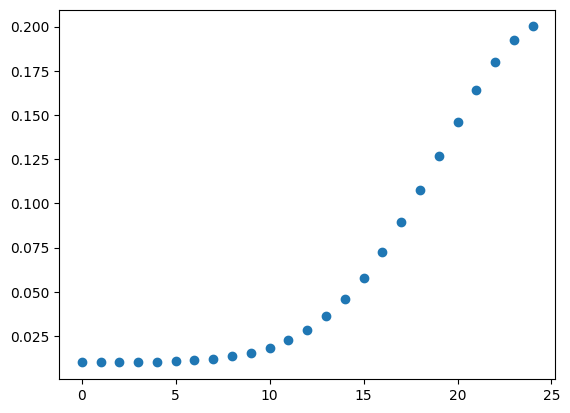

In [132]:
# build a random sampler with uneven distribution
import matplotlib.pyplot as plt

sample_ratio_min, sample_ratio_max = 0.01, 0.2
num_bins = 25
span = 1800
interval = timedelta(seconds=span//num_bins)

def normal(x, mu=num_bins, sigma=num_bins//4):
    return ( 2.*np.pi*sigma**2. )**-.5 * np.exp( -.5 * (x-mu)**2. / sigma**2. )

sample_ratios = [normal(i) for i in range(num_bins)]
# normalize to a certain range
factor = (sample_ratio_max - sample_ratio_min) / (max(sample_ratios) - min(sample_ratios))
sample_ratios = [s * factor + sample_ratio_min for s in sample_ratios]

plt.scatter(range(num_bins), sample_ratios)
plt.show()

In [133]:
# sample from df by given distribution
def sample_by_distribution(df, row, sample_ratios, interval):
    selected_ids = []
    num_bins = len(sample_ratios)
    t = row.datetime
    df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
    touched_ids = []
    for bi in range(num_bins):
        t1 = str(t - interval * (bi + 1))[:19]
        t2 = str(t + interval * (bi + 1))[:19]
        sub_df = df[(df.collected_on_str >= t1) & (df.collected_on_str <= t2)]
        sub_df = sub_df[~sub_df.id.isin(touched_ids)]
        touched_ids += sub_df.id.to_list()
        if len(sub_df) > 0:
            # sub_df = sub_df.sort_values('collected_on')
            # print(bi, t1, sub_df.iloc[0].collected_on_str, t2, sub_df.iloc[-1].collected_on_str, sub_df.shape)
            selected_df = sub_df.sample(frac=sample_ratios[num_bins-1-bi])
            # print(sub_df.shape, sample_ratios[num_bins-1-bi], selected_df.shape)
            selected_ids += selected_df.id.to_list()
    return selected_ids

selected_ids = []
for i, row in df2.iterrows():
    df = dfs[i]
    df = df[df.camera_location == row.camera_location]
    _selected_ids = sample_by_distribution(df, row, sample_ratios, interval)
    print(i, row.robot_name, row.collected_on, row.camera_location, len(dfs[i]), len(df), len(_selected_ids))
    selected_ids += _selected_ids
selected_ids = list(set(selected_ids))
print(len(selected_ids))

/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

0 1RW8370DEPL806211 2024-11-11T22:14:18.137000 T02 264 33 7
1 1RW8410DAPB240014 2024-08-22T22:16:59.309000 T02 1848 99 9
2 1RW8410DAPB240014 2024-10-11T21:43:42.120000 T06 4752 297 22
3 1RW8410DCPB221646 2024-10-22T21:47:25.309000 T13 3094 386 36
4 1RW8410DHPB240016 2024-10-12T13:28:43.529000 T10 528 66 10
5 1RW8410DPPK808013 2024-08-13T23:28:06.155000 T02 2400 150 15


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

6 1RW8410DPPK808013 2024-08-14T19:06:12.136000 T02 4808 300 34
7 1RW8410DPPK808013 2024-08-14T19:17:30.124000 T02 4808 300 40
8 1RW8410DPPK808013 2024-08-14T19:50:23.149000 T02 1376 86 17
9 1RW8410DPPK808013 2024-08-14T17:37:54.106000 T01 8921 556 42
10 1RW8410DPPK808013 2024-08-14T17:44:48.025000 T01 9601 598 65
11 1RW8410DPPK808013 2024-08-14T17:47:46.180000 T01 9609 599 66
12 1RW8410DPPK808013 2024-08-14T17:55:39.040000 T01 9609 599 56
13 1RW8410DPPK808013 2024-08-15T17:26:01.040000 T02 3440 215 33
14 1RW8410DPPK808013 2024-08-15T17:29:51.143000 T02 3440 215 31
15 1RW8410DPPK808013 2024-08-15T17:42:54.026000 T02 5494 343 15
16 1RW8410DPPK808013 2024-08-15T18:01:05.267000 T02 4117 257 22


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

17 1RW8410DPPK808013 2024-08-15T18:25:03.161000 T02 4805 300 25
18 1RW8410DPPK808013 2024-08-15T05:20:29.689000 T02 6871 429 22
19 1RW8410DPPK808013 2024-08-15T05:34:29.182000 T02 9966 601 39
20 1RW8410DPPK808013 2024-08-15T05:46:18.139000 T01 9286 559 47
21 1RW8410DPPK808013 2024-08-15T05:52:59.071000 T02 7911 473 47


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

22 1RW8410DPPK808013 2024-08-15T06:18:03.565000 T06 6868 429 51
23 1RW8410DPPK808013 2024-08-15T06:19:07.168000 T10 6868 429 51
24 1RW8410DPPK808013 2024-08-15T08:34:26.391000 T13 2328 167 31
25 1RW8410DPPK808013 2024-08-28T20:34:29.434000 T01 1061 66 10
26 1RW8410DPPK808013 2024-08-26T21:46:46.355000 T02 2640 165 11
27 1RW8410DPPK808013 2024-08-22T01:49:29.640000 T02 1585 99 13


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

28 1RW8410DPPK808013 2024-08-22T03:46:56.187000 T02 5280 330 42
29 1RW8410DPPK808013 2024-08-22T03:48:29.760000 T02 5280 330 48
30 1RW8410DPPK808013 2024-08-22T03:49:46.683000 T02 5280 330 51
31 1RW8410DPPK808013 2024-08-22T03:53:25.131000 T02 5280 330 52
32 1RW8410DPPK808013 2024-08-22T17:14:47.618000 T02 3697 231 25


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

33 1RW8410DPPM806217 2024-10-23T17:11:42.038000 I02 51232 2593 122
34 1RW8410DTNB203842 2024-11-17T05:48:04.232000 T10 1055 132 15
35 1RW8410DTNB203842 2024-11-13T03:13:42.314000 T13 794 99 20
36 1RW8410DTPK808012 2024-11-06T19:31:59.103000 T06 41928 2545 251
37 1RW8410DVPB221767 2024-09-10T19:04:35.546000 T02 5090 269 29


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

38 1RW8410DVPB240013 2024-08-15T05:24:28.089000 T06 6324 395 34
39 1RW8410DVPB240013 2024-08-15T06:44:53.592000 T02 6023 377 41
40 1RW8410DVPB240013 2024-08-15T08:37:37.434000 T02 2064 172 10
41 1RW8410DVPB240013 2024-08-15T09:06:25.038000 T02 2408 215 22
42 1RW8410DVPB240013 2024-08-15T04:58:24.321000 T02 3296 206 17
43 1RW8410DVPB240013 2024-08-15T06:25:55.398000 T09 2064 129 25


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

44 1RW8410DVPB240013 2024-08-15T03:22:10.296000 T02 2752 172 23
45 1RW8410DVPB240013 2024-08-14T00:19:12.166000 T01 2696 176 20
46 1RW8410DVPB240013 2024-08-14T04:56:22.778000 T02 11657 727 40
47 1RW8410DVPB240013 2024-08-14T06:45:35.219000 T02 2744 171 28
48 1RW8410DVPB240013 2024-08-13T04:50:42.302000 T02 15189 963 82


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

49 1RW8410DVPB240013 2024-08-13T04:52:13.211000 T02 14685 930 84
50 1RW8410DVPB240013 2024-08-13T04:53:36.128000 T02 14197 899 83
51 1RW8410DVPB240013 2024-08-13T04:55:03.041000 T02 14197 899 81
52 1RW8410DVPB240013 2024-08-13T04:56:09.308000 T02 13712 869 84


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

53 1RW8410DVPB240013 2024-08-13T04:57:45.212000 T02 13712 869 81
54 1RW8410DVPB240013 2024-08-13T04:58:46.484000 T02 13712 869 79
55 1RW8410DVPB240013 2024-08-13T05:01:32.318000 T02 13712 869 73
56 1RW8410DVPB240013 2024-08-13T05:15:36.140000 T02 11279 717 47
57 1RW8410DVPB240013 2024-08-13T05:17:27.362000 T02 10777 685 45


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

58 1RW8410DVPB240013 2024-08-20T14:39:35.133000 T13 6865 429 29
59 1RW8410DVPB240013 2024-08-22T19:05:17.100000 T02 6869 429 36
60 1RW8410DVPB240013 2024-08-28T19:20:58.263000 T02 7393 496 34
61 1RW9640DCRJ825870 2024-10-24T16:58:44.031000 T14 264 33 7
62 1RW9640DKPA085013 2024-09-05T19:45:59.317000 T06 1058 66 12
63 1RW9640DKPA085013 2024-09-05T21:42:25.612000 T14 1583 99 13


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

64 1RW9640DKPA085013 2024-09-05T21:44:20.497000 T14 1583 99 13
65 1RW9640DKPA085013 2024-09-05T22:05:16.240000 T06 1847 98 7
66 1RW9640DKPA085013 2024-09-07T16:56:09.164000 T14 796 100 18
67 1RW9640DKPA085013 2024-09-05T21:46:44.020000 T14 3172 198 29
68 1RW9640DKPA085013 2024-09-05T21:49:50.167000 T06 4228 265 33
69 1RW9640DKPA085013 2024-09-05T21:51:33.064000 T06 4228 265 34
70 1RW9640DKPA085013 2024-09-05T21:53:08.302000 T06 4228 265 32


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

71 1RW9640DKPA085013 2024-09-05T22:01:34.129000 T02 4228 264 19
72 1RW9640DKPA085013 2024-09-05T17:11:54.238000 T06 2638 165 26
73 1RW9640DKPA085013 2024-09-05T17:15:09.376000 T05 2638 165 29
74 1RW9640DKPA085013 2024-09-05T17:37:13.051000 T06 3131 193 25
75 1RW9640DKPA085013 2024-09-05T17:38:25.312000 T01 3662 227 27
76 1RW9640DKPA085013 2024-09-05T18:07:36.559000 T02 2608 160 13
77 1RW9640DKPA085013 2024-09-05T18:09:31.111000 T02 2080 127 13


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

78 1RW9640DKPA085013 2024-09-07T19:53:39.030000 T13 2108 263 30
79 1RW9640DKPA085013 2024-09-07T20:01:53.202000 T13 2108 263 40
80 1RW9640DKPA085013 2024-09-07T20:03:45.090000 T14 2108 264 37
81 1RW9640DKPA085013 2024-10-17T23:30:21.282000 T14 1569 196 20
82 1RW9640DLPJ822282 2024-08-29T15:43:28.525000 I02 5017 264 20
83 1RW9640DPNJ820391 2024-08-22T01:36:00.125000 T02 4118 257 26


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

84 1RW9640DPNJ820391 2024-08-22T03:50:48.282000 T01 3433 171 21
85 1RW9640DPNJ820391 2024-08-22T03:42:43.101000 T02 4798 299 34
86 1RW9640DPNJ820391 2024-08-22T01:10:21.665000 T02 1032 86 17
87 1RW9640DTPJ822451 2024-08-01T21:07:54.214000 T13 6861 430 38
88 1RW9640DTPJ822451 2024-08-06T21:04:40.313000 T02 7258 454 36
89 1RW9640DTPJ822451 2024-08-06T22:32:01.058000 T02 13267 828 57


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

90 1RW9640DTPJ822451 2024-08-15T20:41:49.100000 T02 4660 582 55
91 1RW9640DTPJ822451 2024-08-15T20:54:14.021000 T02 6004 750 62
92 1RW9640DTPJ822451 2024-08-15T21:11:06.008000 T02 5412 676 57
93 1RW9640DTPJ822451 2024-08-15T21:12:10.277000 T02 5240 655 57
94 1RW9640DTPJ822451 2024-08-15T21:45:18.086000 T02 3181 398 53


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

95 1RW9640DTPJ822451 2024-10-03T20:41:12.097000 T02 7751 484 38
96 1RW9640DTPJ822451 2024-08-02T17:52:30.037000 T02 4810 300 23
97 1RW9640DTPJ822451 2024-08-02T18:31:15.043000 T02 6873 429 41
98 1RW9640DTPJ822451 2024-08-02T18:33:15.256000 T02 6873 429 37
99 1RW9640DVPJ822411 2024-08-12T18:29:32.139000 T05 11264 704 70


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22


100 1RW9640DVPJ822411 2024-08-12T17:07:29.067000 T02 72337 4521 436
101 1RW9640DVPJ822411 2024-08-12T18:01:46.140000 T14 78524 4911 288


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22


102 1RW9640DVPJ822411 2024-08-12T18:31:08.043000 T02 107862 6739 495
103 1RW9640DVPJ822411 2024-08-12T18:34:29.175000 T13 106223 6642 479


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22


104 1RW9640DVPJ822411 2024-08-12T18:35:16.128000 T13 107811 6741 475
105 1RW9640DVPJ822411 2024-08-12T18:37:16.008000 T02 111891 6991 477


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22


106 1RW9640DVPJ822411 2024-08-12T18:38:01.296000 T05 114051 7124 479
107 1RW9640DVPJ822411 2024-08-12T18:43:50.281000 T02 121187 7572 528


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22


108 1RW9640DVPJ822411 2024-08-12T18:45:43.167000 T01 117267 7326 537
109 1RW9640DVPJ822411 2024-08-12T18:47:16.074000 T02 115731 7231 537


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22


110 1RW9640DVPJ822411 2024-08-12T19:44:26.307000 T14 106479 6648 406
111 1RW9640DVPJ822411 2024-08-12T20:11:06.039000 T13 55721 3472 276


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

112 1RW9640DVPJ822411 2024-08-12T14:44:35.150000 T09 108680 6793 606
113 1RW9640DVPJ822411 2024-08-12T17:35:33.048000 T02 36406 2278 340
114 1RW9640DVPJ822411 2024-08-22T20:55:01.377000 T02 3699 232 26
115 1RW9640DVPJ822411 2024-08-22T21:55:30.078000 T14 7857 491 37
116 1RW9640DVPJ822411 2024-08-24T01:31:44.646000 T02 2117 132 25
117 1RW9640DVPJ822411 2024-08-23T22:27:59.356000 T05 2640 165 20


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

118 1RW9640DVPJ822411 2024-08-24T01:38:06.264000 T05 10943 685 65
119 1RW9640DVPJ822411 2024-08-24T01:39:34.842000 T01 10943 686 70
120 1RW9640DVPJ822411 2024-08-24T01:48:10.659000 T13 9359 585 68
121 1RW9640DVPJ822411 2024-08-26T17:49:38.446000 T02 1056 66 12
122 1RW9640DVPJ822411 2024-08-25T18:01:22.656000 T02 3170 198 28


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

123 1RW9640DVPJ822411 2024-08-27T01:59:01.605000 T02 6768 423 32
124 1RW9640DVPJ822411 2024-08-27T23:53:24.166000 T14 7602 477 16
125 1RW9640DVPJ822411 2024-08-28T15:06:03.322000 T13 5328 333 27
126 1RW9640DVPJ822411 2024-08-28T01:21:44.527000 T02 3612 224 38
127 1RW9640DVPJ822411 2024-08-28T18:54:15.154000 T02 20156 1259 42


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

128 1RW9640DVPJ822411 2024-08-28T18:58:28.234000 T02 25228 1576 54
129 1RW9640DVPJ822411 2024-08-28T18:59:46.156000 T02 25228 1576 60
130 1RW9640DVPJ822411 2024-08-28T21:08:44.542000 T13 5085 318 24
131 bedrock_391 2024-07-25T19:17:40.237000 T01 7216 450 45


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

132 bedrock_391 2024-07-30T01:07:17 T01 80688 5041 417
133 bedrock_391 2024-07-29T19:24:52.005000 T10 2064 129 25
134 bedrock_40013 2024-08-07T03:41:53.267000 T05 7538 469 43
135 bedrock_40013 2024-08-09T22:37:44.305000 T02 2064 129 18
136 bedrock_40013 2024-07-30T18:28:06.120000 T14 2728 172 18
137 bedrock_40013 2024-07-31T19:21:10.247000 T02 2064 129 13


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

138 bedrock_40013 2024-07-31T21:02:42.149000 T02 3440 215 23
139 bedrock_411 2024-08-01T14:02:05.033000 T02 39057 2442 396
140 bedrock_5013 2024-08-06T23:28:31.120000 T06 7586 470 22
141 bedrock_5013 2024-08-07T00:13:08.107000 T02 16442 1022 83
142 bedrock_5013 2024-08-06T17:21:02.188000 T06 2048 127 13


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

143 bedrock_5013 2024-08-06T17:59:23.218000 T14 6142 385 58
144 bedrock_5013 2024-08-06T18:02:01.060000 T14 6142 385 64
145 bedrock_5013 2024-08-06T18:04:25.249000 T14 6142 385 64
146 bedrock_5013 2024-08-06T18:05:51.163000 T14 6142 385 61
147 bedrock_5013 2024-08-03T00:20:23.464000 T02 5500 344 32
148 bedrock_5013 2024-08-03T00:36:53.140000 T02 7555 472 27


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

149 bedrock_5013 2024-08-01T17:01:39.041000 T02 3152 197 19
150 bedrock_5013 2024-07-31T22:28:31.032000 T10 9617 602 64
151 bedrock_5013 2024-07-31T22:31:53.163000 T09 10305 645 76
152 bedrock_5013 2024-07-31T22:33:37.059000 T09 10305 645 78
153 bedrock_5013 2024-07-31T22:34:39.330000 T09 10305 645 78


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

154 bedrock_8013 2024-07-30T20:25:20.064000 T06 13558 849 47
155 bedrock_8013 2024-07-30T18:09:30.222000 T06 1376 86 17
156 bedrock_8013 2024-07-30T18:10:27.165000 T06 1376 86 17
157 bedrock_8013 2024-07-31T17:11:33.185000 T02 7644 477 37
158 bedrock_8013 2024-07-31T17:38:49.214000 T10 4804 300 24
159 bedrock_8013 2024-08-06T18:26:54.235000 T10 5496 344 34


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

160 bedrock_8013 2024-08-06T19:18:26.140000 T02 8183 514 46
161 bedrock_8013 2024-08-06T20:27:06.203000 T02 4783 297 30
162 bedrock_8013 2024-08-03T18:01:26.225000 T01 6156 383 34
163 bedrock_8013 2024-08-03T18:17:28.262000 T02 7543 469 31
164 bedrock_8013 2024-08-03T19:06:11.003000 T05 9585 595 62


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

165 bedrock_8013 2024-08-03T16:59:46.928000 T02 3801 236 29
166 bedrock_8013 2024-08-03T17:05:28.586000 T02 3561 221 23
167 bedrock_8013 2024-08-09T22:39:50.537000 T02 688 43 9
168 bedrock_8013 2024-08-12T21:59:13.085000 T09 2192 137 21
12241


/tmp/ipykernel_3238149/3384661366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['collected_on_str'] = df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22


In [134]:
selected_df = fdf[fdf.id.isin(selected_ids)]
selected_df.shape

(12102, 8)

In [139]:
selected_df['collected_on_str'] = selected_df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22
df4 = selected_df.groupby(['collected_on_str']).first().reset_index()  # take only 1 image per second
print(selected_df.shape, df4.shape)

(12102, 10) (8260, 10)


/tmp/ipykernel_3238149/1308913343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['collected_on_str'] = selected_df['collected_on'].apply(lambda c: str(c)[:19])  # 2024-07-24 21:08:22


### Search around geohash and time

In [7]:
import ast
from datetime import datetime, timedelta
from jupiterdata.utils.dataset import query_db

def get_fn_geohash6_bag_name(root_dir, pred_dir, model, dataset):
    # load dataset df
    csv = os.path.join(root_dir, dataset, 'master_annotations.csv')
    converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
    df = pd.read_csv(csv, converters=converters)
    df['geohash6'] = df['geohash'].apply(lambda g: g[:6])
    print(df.shape)

    # load pred fns
    sum_pred_dir = os.path.join(pred_dir, model, dataset, 'false_negative_sum5')
    fn_ids = os.listdir(sum_pred_dir)
    unique_ids = [f[:-4] for f in fn_ids]

    # get fn df
    fn_df = df[df.unique_id.isin(unique_ids)]
    return fn_df

In [25]:
# read in geohash table
geohash_table = '/data/jupiter/li.yu/data/halo_hard_cases/20240328_geohash_table_v8_1_rc.csv'
geohash_df = pd.read_csv(geohash_table)
geohash6_train_list = geohash_df[geohash_df.bucket == 'train'].geohash6.to_list()
geohash6_test_list = geohash_df[geohash_df.bucket == 'test'].geohash6.to_list()
print(geohash_df.shape, len(geohash6_train_list), len(geohash6_test_list))

(2101, 2) 1672 371


In [8]:
mcsv = '/data2/jupiter/datasets/halo_rgb_stereo_train_v8_1/master_annotations.csv'
mdf = pd.read_csv(mcsv)
print(mdf.shape)

root_dir = '/data/jupiter/datasets/safety_datasets/'
pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model'
model = 'v81_nextvitsmall_dust_only_kore_dean_0406'
datasets = [
    "humans/on_path_forward/on_path_forward_humans_night_2024_rev2_v10", 
    "humans/on_path_aft/on_path_aft_humans_night_2024_rev2_v10",
]
fn_dfs = [get_fn_geohash6_bag_name(root_dir, pred_dir, model, dataset) for dataset in datasets]
fn_df = pd.concat(fn_dfs, ignore_index=True)
print(fn_df.shape)
print(len(fn_df.bag_name.unique()), len(fn_df.geohash6.unique()))

(326871, 359)


/tmp/ipykernel_121511/3595870924.py:9: DtypeWarning: Columns (23,37,132,150,168,184,188,196,218,219) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv, converters=converters)


(4251, 332)
(2260, 332)
(651, 333)
187 23


/tmp/ipykernel_121511/3595870924.py:9: DtypeWarning: Columns (164,165,172,174,184,213,218,219,222,224,239,273,274) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv, converters=converters)


In [9]:
g = fn_df.groupby(['geohash6', 'bag_name']).size()
keys = g.index
d = [[k, g[k]] for k in keys]
d = sorted(d, key=lambda k: k[1], reverse=True)
d[:5]

[[('9v6tpg', '02_14_2024-00_50_50'), 27],
 [('9zpund', '10_21_2023-00_44_44'), 17],
 [('9v6tps', '02_21_2024-01_24_00'), 16],
 [('9zsx7q', '11_06_2023-23_46_58'), 15],
 [('9v6tpg', '02_17_2024-01_35_37'), 14]]

In [14]:
# get collection time of fn images in a bag
def get_start_end_time_of_bag(fn_df, bag_name):
    # bag_name = '02_21_2024-01_24_00'
    bag_df = fn_df[fn_df.bag_name == bag_name]
    bag_df = bag_df.sort_values('collected_on')
    bag_df['datetime'] = bag_df.collected_on.apply(datetime.fromisoformat)
    delta = timedelta(seconds=60*30)
    # print(bag_df.shape)
    # print(bag_df.iloc[0].datetime, bag_df.iloc[-1].datetime)
    # print(bag_df.iloc[0].datetime - delta, bag_df.iloc[-1].datetime + delta)
    return bag_df.iloc[0].datetime - delta, bag_df.iloc[-1].datetime + delta

In [19]:
dfs = {}
for (geohash6, bag_name), N in d:
    t1, t2 = get_start_end_time_of_bag(fn_df, bag_name)

    query = f"""
    SELECT
        IMJ.id AS id,
        IMJ.robot_name AS robot_name,
        IMJ.camera_location AS camera_location,
        IMJ.operating_field_name AS operating_field_name,
        IMJ.bag_name AS bag_name,
        IMJ.collected_on AS collected_on,
        IMJ.hard_drive_name AS hard_drive_name,
        IMJ.geohash AS geohash
    FROM
        mesa_prod.mesa_lake_prod.image_jupiter AS IMJ
    WHERE
        bag_name = '{bag_name}'
        AND collected_on > '{str(t1)[:19]}'
        AND collected_on <= '{str(t2)[:19]}'
    """

    df = query_db(query)
    print(geohash6, bag_name, t1, t2, len(df))
    dfs[(geohash6, bag_name)] = df
    # break

9v6tpg 02_14_2024-00_50_50 2024-02-14 00:21:43.138000 2024-02-14 01:22:19.165000 2078
9zpund 10_21_2023-00_44_44 2023-10-21 00:15:52.182000 2023-10-21 01:16:38.163000 921
9v6tps 02_21_2024-01_24_00 2024-02-21 00:54:22.037000 2024-02-21 01:54:43.033000 3377
9zsx7q 11_06_2023-23_46_58 2023-11-06 23:17:33.235000 2023-11-07 00:18:47.270000 1048
9v6tpg 02_17_2024-01_35_37 2024-02-17 01:06:00.170000 2024-02-17 02:07:00.095000 1616
9v6tpg 02_21_2024-01_02_22 2024-02-21 00:33:58.630000 2024-02-21 01:34:45.661000 2062
9v6tpg 02_24_2024-00_54_03 2024-02-24 00:24:42.477000 2024-02-24 01:25:06.534000 1459
9zmjkf 11_18_2023-02_58_58 2023-11-18 02:30:22.710000 2023-11-18 03:30:47.680000 960
9zmjkf 11_17_2023-23_45_45 2023-11-17 23:16:29.858000 2023-11-18 00:17:37.874000 921
9v6tpg 02_25_2024-01_27_28 2024-02-25 00:58:04.455000 2024-02-25 01:58:22.454000 959
9v6tpg 02_14_2024-00_52_52 2024-02-14 00:23:13.958000 2024-02-14 01:23:32.119000 1182
9v6tpg 02_14_2024-03_00_10 2024-02-14 02:30:58.970000 2024

In [40]:
total = 0
use_df = None
for (geohash6, bag_name), df in dfs.items():
    df['geohash6'] = df['geohash'].apply(lambda g: g[:6])
    # _df = df[(df.geohash6 != '7zzzzz') & (~df.geohash6.isin(geohash6_test_list))]
    _df = df[(~df.geohash6.isin(geohash6_test_list))]
    if len(_df) > 0:
        use_df = _df if len(_df) > 200 else use_df
        total += len(_df)
        print(geohash6, bag_name, _df.shape)
        print(_df.sample(min(5, len(_df))).id.to_list())
        # if len(_df[_df.id == '654bdc10851dd6051c9a2d4b']) > 0:
        #     print(_df[_df.id == '654bdc10851dd6051c9a2d4b'].geohash.to_list())
print(total)

9v6tpg 02_14_2024-00_50_50 (554, 9)
['65ea454263edec78ede83128', '65ea42b9936e32acd000c032', '65ea4a7c000669bb859209b4', '65ea482b71e1684babf8f77f', '65ea462bbf9244df1b4d852e']
9v6tps 02_21_2024-01_24_00 (904, 9)
['65e9cdab3de3d70fe449654b', '65ea0b36000669bb8591757d', '65e9d226e879f487a282a835', '65e9d004cafc4e811b02af3d', '65e9d12bf2f15c5f2ceaa879']
9zsx7q 11_06_2023-23_46_58 (88, 9)
['654bdc741094059fbafd8f00', '654bdc6334b229e20d4375a9', '654bdc2200210142b9092ba1', '654bdbd9fa83693bde13c334', '654bdc32f99b22029bd77dbb']
9v6tpg 02_17_2024-01_35_37 (445, 9)
['65e9c01ebc620c2c14fe4026', '65e9c0945e301af12dab0518', '65e9c12a2bbbdbae66cedae3', '65e9bdb5f04f29f44a32c6ab', '65e9c0784875033da61a0078']
9v6tpg 02_21_2024-01_02_22 (539, 9)
['65ea06aedb75a515c2d7ad48', '65e9ffc6459275487d44b70b', '65ea00ca6592f96a05175cee', '65ea01c0d80ab49742253a49', '65ea06f706198505e2a64568']
9v6tpg 02_24_2024-00_54_03 (396, 9)
['65e7c3694875033da61782fb', '65e7c80ddc04dc9d140eb419', '65e7c5a94875033da61787

In [41]:
use_df.geohash6.unique()

array(['7zzzzz'], dtype=object)

## Create a dataset

### Some filtering

In [47]:
# model false positives
pred_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model'
models = [
    'kore_5_h',
    'kore_10_lo_10_tr',
]
dataset = 'fps_datasets/halo_pivot_voltage_culvert_data_8012_oct'
fp_ids, fp_uids = [], []
for model in models:
    pred_df = pd.read_csv(os.path.join(os.path.join(pred_dir, model, dataset, 'output.csv')))
    fp_df = pred_df[pred_df.result_state == 'false_positive']
    print(model, pred_df.shape, fp_df.shape)
    fp_ids += fp_df.id.to_list()
    fp_uids += fp_df.unique_id.to_list()
fp_ids = list(set(fp_ids))
fp_uids = list(set(fp_uids))
print(len(fp_ids), len(fp_uids))

kore_5_h (56065, 23) (7425, 23)
kore_10_lo_10_tr (56065, 23) (7987, 23)
6707 8009


In [38]:
df3 = df2[df2.id.isin(fp_ids)]
print(df2.shape, df3.shape)
df3.special_notes.unique()

(74864, 12) (6707, 12)


array(['jason zaman high voltage lines', 'Pivot House',
       'irrigation hut + water tank', 'pivot headland pass',
       'irrigation pivot headland', 'pivot headlands',
       'Jason Zaman High voltage Lines', 'Road Culvert left of tractor'],
      dtype=object)

In [49]:
mdf = pd.read_csv('/data2/jupiter/datasets/fps_datasets/halo_pivot_voltage_culvert_data_8012_oct/master_annotations.csv')
fp_mdf = mdf[mdf.unique_id.isin(fp_uids)]
print(mdf.shape, fp_mdf.shape)
fp_mdf.to_csv('/data2/jupiter/datasets/fps_datasets/halo_pivot_voltage_culvert_data_8012_oct/master_annotations_fps.csv', index=False)

/tmp/ipykernel_1200557/2618062599.py:1: DtypeWarning: Columns (103,106) have mixed types. Specify dtype option on import or set low_memory=False.
  mdf = pd.read_csv('/data2/jupiter/datasets/fps_datasets/halo_pivot_voltage_culvert_data_8012_oct/master_annotations.csv')


(56065, 155) (8009, 155)


In [7]:
# dedup by image similarity
dedup_df = pd.read_csv('/data3/jupiter/datasets/model_positive/halo_small_plant_stops_2024_07_11_candidates/image_similarity_reduced_1.csv')
# dedup_df = pd.read_csv('/data3/jupiter/datasets/model_positive/halo_manure_data_candidate/image_similarity_clustered.csv')
print(dedup_df.shape)

(4267, 127)


In [47]:
# csv = '/data/jupiter/datasets/dust_datasets/halo_human_with_dust_on_lens_jf163_2nd/selected_for_label.csv'
csv = '/data/jupiter/li.yu/data/halo_fps_cases/tall_weeds/aletheia_stops_corrected_as_small_plant_not_in_train_2024_07_11.csv'
df = pd.read_csv(csv)
print(df.shape, 'id' in df, 'unique_id' in df)

(455, 14) True False


In [67]:
df = df[~df.id.isin(test_df.id)]
df.shape

(6383, 163)

In [10]:
triage_ids = ['66a84455f9807557db40d8fc',
 '66ce211cf652389e420cd5c1']
print(len(triage_ids))
df = df[~df.id.isin(triage_ids)]
df.shape

2


(2293, 221)

In [9]:
# dfs = []
dfs.append(dedup_df)
df2 = pd.concat(dfs, ignore_index=True)
df2.shape

(4454, 132)

### Dataset creation

In [79]:
# unlabeled dataset
Dataset.create(
    name="halo_spark_stop_events_2024_spring_for_labeling",
    description="2325 train geohash images matched by spark engagements, rev2 data from january to june 2024, predicted as human/vehicle/lo and corrected as no object, filtered by existing datasets and labeled images",
    kind='image',  # annotation or image
    image_ids=train_df.id.to_list())

{}

In [65]:
# labeled, stereo dataset
imageids_to_dataset(
    image_ids=df.id.to_list(),
    dataset_name="halo_stop_events_2024_spring_seed_labeled",
    dataset_description="check labeled images in halo_stop_events_2024_spring_seed from 8739 images",
    dataset_kind='pixelwise_annotation',  # image or categorical_annotation or pixelwise_annotation
    mode='stereo',  # stereo or mono
    production_dataset=False,
)

Warning 6386 images do not have a corresponding annotation.
Preparing stereo dataframe for {'T01': 'T03', 'T02': 'T04', 'T05': 'T07', 'T06': 'T08', 'T09': 'T11', 'T10': 'T12', 'T13': 'T15', 'T14': 'T16', 'I01': 'I03', 'I02': 'I04'}...
Size of left dataframe: 2353
Size of stereo dataframe: 2351
Preparing stereo dataframe for {'T02': 'T03', 'T06': 'T07', 'T10': 'T11', 'T14': 'T15', 'I02': 'I03'}...
Size of left dataframe: 1671
Size of stereo dataframe: 1671
Sending 2351 annotated_ids for creating dataset
Time taken to prepare data for dataset creation job: 1.12 mins


In [27]:
# unlabeled, stereo dataset
imageids_to_dataset(
    image_ids=test_df2.id.to_list(),
    dataset_name="halo_tall_weeds_prod_v0",
    dataset_description="3027 images dedupped from halo_small_plant_stops_2024_07_11_candidates plus 187 stop events images, in test geohash",
    dataset_kind='image',  # image or categorical_annotation or pixelwise_annotation
    mode='stereo',  # stereo or mono
    production_dataset=False,
)

Preparing stereo dataframe for {'T01': 'T03', 'T02': 'T04', 'T05': 'T07', 'T06': 'T08', 'T09': 'T11', 'T10': 'T12', 'T13': 'T15', 'T14': 'T16', 'I01': 'I03', 'I02': 'I04'}...
Size of left dataframe: 3027
Size of stereo dataframe: 3023
Preparing stereo dataframe for {'T02': 'T03', 'T06': 'T07', 'T10': 'T11', 'T14': 'T15', 'I02': 'I03'}...
Size of left dataframe: 1576
Size of stereo dataframe: 1574
Sending 7590 image ids for creating dataset
Time taken to prepare data for dataset creation job: 0.71 mins


## Download a dataset

In [45]:
# to download large image dataset and save in jpg format, change the following files
# note original files are ending with .bk, and changed files are ending with .save_jpg
# /home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/brtdevkit/data/core/dataset.py
# /home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/brtdevkit/util/aws/s3.py
# /home/li.yu/anaconda3/envs/brtdevkit/lib/python3.9/site-packages/brtdevkit/data/core/dataset.py  # save only one png file

In [141]:
dataset_name = 'halo_small_plant_stops_2024_07_11_candidates'
# dataset_dir = os.path.join('/data/jupiter/datasets/dust_datasets', dataset_name)
# dataset_dir = os.path.join('/data2/jupiter/datasets', dataset_name)
# dataset_dir = os.path.join('/data/jupiter/li.yu/data/dust_data_colletion_for_july_1st', dataset_name)
# dataset_dir = os.path.join('/data/jupiter/datasets/image_quality_datasets', dataset_name)
dataset_dir = os.path.join('/data3/jupiter/datasets/model_positive', dataset_name)
os.makedirs(dataset_dir, exist_ok=True)

test_dataset = Dataset.retrieve(name=dataset_name)
test_df = test_dataset.to_dataframe()
# test_df.drop(columns=["artifact_raw_0_save_path"], inplace=True, errors="ignore")  # don't download tiff files
test_dataset.download(dataset_dir, df=test_df)

2024-11-21 18:45:54,484 - brtdevkit - INFO - start downloading dataset: 673fee6dc266ae202f2721f5 into /data3/jupiter/datasets/model_positive/halo_small_plant_stops_2024_07_11_candidates
INFO:brtdevkit:start downloading dataset: 673fee6dc266ae202f2721f5 into /data3/jupiter/datasets/model_positive/halo_small_plant_stops_2024_07_11_candidates
/home/li.yu/anaconda3/envs/query/lib/python3.10/site-packages/brtdevkit/data/dataset.py:619: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  keys_with_save_path = keys_with_save_path.append(
/home/li.yu/anaconda3/envs/query/lib/python3.10/site-packages/brtdevkit/data/dataset.py:619: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  keys_with_save_path = keys_with_save_path.append(
100%|██████████| 24202/24202 [05:52<00:00, 68.71it/s] 
2024-11-21 18:51:55,921 - brtdevkit - INFO - 